In [1]:
import os
import platform
import subprocess
import pandas as pd
import numpy
from IPython.display import Image

RUNS = 5

FILENAME = 'CRS.csv'

def system_info():
    print(os.name, platform.system(), platform.release())
    print(os.popen("clinfo | grep -B 2 -A 4 'Device Vendor ID'").read())
    print(os.popen("clinfo | grep NOTE -A 3").read())
    
# Creating Pandas DataFrame 
if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({"version": [], "platform": [], "execution_time_ms": []})
    
# List previous data (average)
df.groupby(['platform', 'version']) \
  .agg({'version':'count', 'execution_time_ms':'mean'}) \
  .rename(columns={'version':'count','version':'executions'})

executions  \
platform                                   version                 
GeForce 920M                               OpenCL              5   
Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz   SYCL                5   
Intel(R) Core(TM) i5-7400 CPU @ 3.00GHz    OpenCL              5   
Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz   OpenCL             10   
                                           OpenMP              5   
                                           SYCL                5   
Intel(R) FPGA Emulation Device             FPGA_SYCL           5   
Intel(R) Graphics Gen8 [0x1616]            OpenCL              5   
                                           SYCL                5   
Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz OpenCL              5   
                                           SYCL                5   

                                                      execution_time_ms  
platform                                   version                       
GeForce 920M                               OpenCL               26149.4  
Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz   SYCL                 59515.0  
Intel(R) Core(TM) i5-7400 CPU @ 3.00GHz    OpenCL               27984.2  
Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz   OpenCL               67072.0  
                                           OpenMP              192705.0  
                                           SYCL                118058.4  
Intel(R) FPGA Emulation Device             FPGA_SYCL           177373.8  
Intel(R) Graphics Gen8 [0x1616]            OpenCL               15187.6  
                                           SYCL                 17543.6  
Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz OpenCL                8936.0  
                                           SYCL                  5516.8

# MacBook Pro (13-inch, 2017)

In [2]:
system_info()

('posix', 'Darwin', '19.4.0')
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel
  Device Vendor ID                                0xffffffff
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.1
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     CPU
--
--
  Device Name                                     Intel(R) Iris(TM) Plus Graphics 640
  Device Vendor                                   Intel Inc.
  Device Vendor ID                                0x1024500
  Device Version                                  OpenCL 1.2 
  Driver Version                                  1.2(Mar 15 2020 21:29:48)
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     GPU



# MacBook Pro (13-inch, 2017) + Docker

In [11]:
system_info()

posix Linux 4.19.76-linuxkit
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.9.3.0.08_110447.xmain
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.10.4.0.15
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU



# GPU-server (Hermes) + Docker (oneAPI)

In [3]:
system_info()

posix Linux 4.15.0-65-generic
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.9.3.0.08_110447.xmain
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Xeon(R) Silver 4208 CPU @ 2.10GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.10.4.0.15
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU




## PC João ACER Aspire E 15

In [4]:
system_info()

posix Linux 5.4.0-52-generic
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.11.8.0.27
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.11.8.0.27
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU
--
  Device Name                 

# João (Desktop)

In [3]:
system_info()

posix Linux 5.4.0-56-generic
  Device Name                                     Intel(R) FPGA Emulation Device
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x1172
  Device Version                                  OpenCL 1.2 
  Driver Version                                  2020.11.8.0.27
  Device OpenCL C Version                         OpenCL C 1.2 
  Device Type                                     Accelerator
--
  Device Name                                     Intel(R) Core(TM) i5-7400 CPU @ 3.00GHz
  Device Vendor                                   Intel(R) Corporation
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 2.1 (Build 0)
  Driver Version                                  2020.11.8.0.27
  Device OpenCL C Version                         OpenCL C 2.0 
  Device Type                                     CPU
--
  Device Name                  

## OpenCL version

In [4]:
for i in range(RUNS): 
    run = subprocess.Popen("./crs-ocl2 -d 4 -aph 600 -apm 50 -a0 -0.7e-3 -a1 0.7e-3 -b0 -1e-7 -b1 1e-7 -c0 1.98e-7 -c1 1.77e-6 -na 5 -nb 5 -nc 5 -tau 0.002 -i ../../../../datasets/simple-synthetic.su -v 0",
                           cwd = "OpenCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

## OpenMP version

In [5]:
for i in range(RUNS): 
    run = subprocess.Popen("./crs-omp2 -aph 600 -apm 50 -a0 -0.7e-3 -a1 0.7e-3 -b0 -1e-7 -b1 1e-7 -c0 1.98e-7 -c1 1.77e-6 -na 5 -nb 5 -nc 5 -tau 0.002 -i ../../../../datasets/simple-synthetic.su -v 0",
                           cwd = "OpenMP/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["OpenMP"], 
                                 "platform"         : ["Intel(R) Core(TM) i5-7400 CPU @ 3.00GHz"], 
                                 "execution_time_ms": [int(result[0])]}))
          
df.to_csv(FILENAME, index = False, header = True)

## SYCL version (using Docker)

In [8]:
for i in range(RUNS): 
    run = subprocess.Popen("./crs-sycl2 -d 4 -aph 600 -apm 50 -a0 -0.7e-3 -a1 0.7e-3 -b0 -1e-7 -b1 1e-7 -c0 1.98e-7 -c1 1.77e-6 -na 5 -nb 5 -nc 5 -tau 0.002 -i ../../../../datasets/simple-synthetic.su -v 0",
                           cwd = "SYCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["SYCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

## FPGA_SYCL version (using Docker)

In [ ]:
for i in range(RUNS): 
    run = subprocess.Popen("./crs-sycl2.fpga_emu -aph 600 -apm 50 -a0 -0.7e-3 -a1 0.7e-3 -b0 -1e-7 -b1 1e-7 -c0 1.98e-7 -c1 1.77e-6 -na 5 -nb 5 -nc 5 -tau 0.002 -i ../../../../datasets/simple-synthetic.su -v 0",
                           cwd = "FPGA_SYCL/build/",
                           shell = True,
                           stdout = subprocess.PIPE,
                           stderr = subprocess.PIPE,
                           universal_newlines = True)
    result = run.communicate()[0].split(",")
    df = df.append(pd.DataFrame({"version"          : ["FPGA_SYCL"], 
                                 "platform"         : [result[0]], 
                                 "execution_time_ms": [int(result[1])]}), sort=False)
          
df.to_csv(FILENAME, index = False, header = True)

In [8]:
df

,version,platform,execution_time_ms
0,SYCL,Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz,58600.0
1,SYCL,Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz,58609.0
2,SYCL,Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz,59390.0
3,SYCL,Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz,62158.0
4,SYCL,Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz,58818.0
...,...,...,...
0,FPGA_SYCL,Intel(R) FPGA Emulation Device,175039.0
0,FPGA_SYCL,Intel(R) FPGA Emulation Device,175892.0
0,FPGA_SYCL,Intel(R) FPGA Emulation Device,179707.0
0,FPGA_SYCL,Intel(R) FPGA Emulation Device,178833.0


Text(0, 0.5, 'Execution time (ms)')

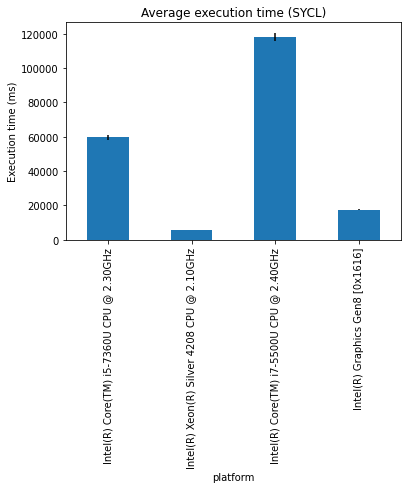

In [10]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df[df.version == 'SYCL'].groupby(by="platform", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std)
plt.set_title("Average execution time (SYCL)")
plt.set_ylabel("Execution time (ms)")

Text(0, 0.5, 'Execution time (ms)')

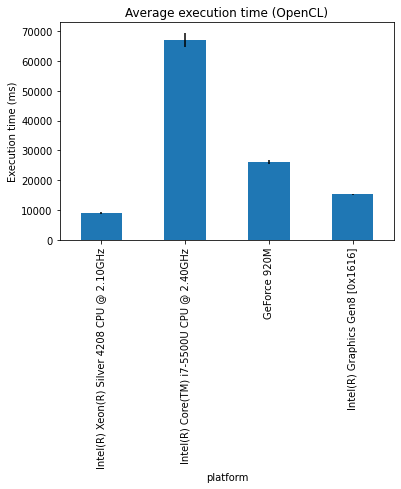

In [12]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df[df.version == 'OpenCL'].groupby(by="platform", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std)
plt.set_title("Average execution time (OpenCL)")
plt.set_ylabel("Execution time (ms)")

Text(0, 0.5, 'Execution time (ms)')

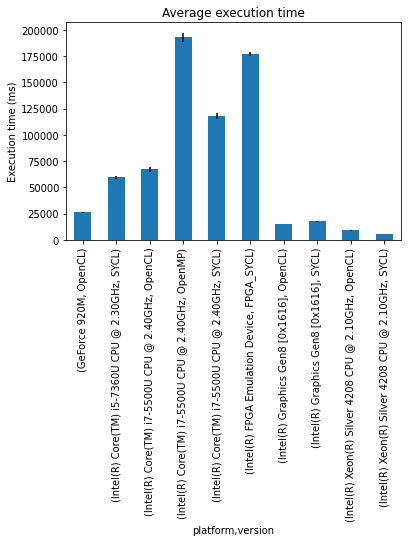

In [13]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df.groupby(['platform', 'version'])
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std)
plt.set_title("Average execution time")
plt.set_ylabel("Execution time (ms)")

In [24]:
#====================================CREATE CRS DIRECTORY FOR IMAGES==================================
os.system("rm -r ../../datasets/CRS")
os.system("mkdir ../../datasets/CRS")

0

In [25]:
#---------------------------------------Generate OpenCL Images----------------------------------------
os.system("suoldtonew < OpenCL/build/crs.a.su | supsimage > ../../datasets/CRS/ocl-crs.a.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/ocl-crs.a.png ../../datasets/CRS/ocl-crs.a.eps")
os.system("suoldtonew < OpenCL/build/crs.b.su | supsimage > ../../datasets/CRS/ocl-crs.b.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/ocl-crs.b.png ../../datasets/CRS/ocl-crs.b.eps")
os.system("suoldtonew < OpenCL/build/crs.c.su | supsimage > ../../datasets/CRS/ocl-crs.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/ocl-crs.c.png ../../datasets/CRS/ocl-crs.c.eps")
os.system("suoldtonew < OpenCL/build/crs.coher.su | supsimage > ../../datasets/CRS/ocl-crs.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/ocl-crs.coher.png ../../datasets/CRS/ocl-crs.coher.eps")
os.system("suoldtonew < OpenCL/build/crs.stack.su | supsimage > ../../datasets/CRS/ocl-crs.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/ocl-crs.stack.png ../../datasets/CRS/ocl-crs.stack.eps")
#---------------------------------------Generate OpenMP Images----------------------------------------
os.system("suoldtonew < OpenMP/build/crs.a.su | supsimage > ../../datasets/CRS/omp-crs.a.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/omp-crs.a.png ../../datasets/CRS/omp-crs.a.eps")
os.system("suoldtonew < OpenMP/build/crs.b.su | supsimage > ../../datasets/CRS/omp-crs.b.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/omp-crs.b.png ../../datasets/CRS/omp-crs.b.eps")
os.system("suoldtonew < OpenMP/build/crs.c.su | supsimage > ../../datasets/CRS/omp-crs.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/omp-crs.c.png ../../datasets/CRS/omp-crs.c.eps")
os.system("suoldtonew < OpenMP/build/crs.coher.su | supsimage > ../../datasets/CRS/omp-crs.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/omp-crs.coher.png ../../datasets/CRS/omp-crs.coher.eps")
os.system("suoldtonew < OpenMP/build/crs.stack.su | supsimage > ../../datasets/CRS/omp-crs.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/omp-crs.stack.png ../../datasets/CRS/omp-crs.stack.eps")
#---------------------------------------Generate SYCL Images----------------------------------------
os.system("suoldtonew < SYCL/build/crs.a.su | supsimage > ../../datasets/CRS/sycl-crs.a.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/sycl-crs.a.png ../../datasets/CRS/sycl-crs.a.eps")
os.system("suoldtonew < SYCL/build/crs.b.su | supsimage > ../../datasets/CRS/sycl-crs.b.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/sycl-crs.b.png ../../datasets/CRS/sycl-crs.b.eps")
os.system("suoldtonew < SYCL/build/crs.c.su | supsimage > ../../datasets/CRS/sycl-crs.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/sycl-crs.c.png ../../datasets/CRS/sycl-crs.c.eps")
os.system("suoldtonew < SYCL/build/crs.coher.su | supsimage > ../../datasets/CRS/sycl-crs.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/sycl-crs.coher.png ../../datasets/CRS/sycl-crs.coher.eps")
os.system("suoldtonew < SYCL/build/crs.stack.su | supsimage > ../../datasets/CRS/sycl-crs.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/sycl-crs.stack.png ../../datasets/CRS/sycl-crs.stack.eps")
#---------------------------------------Generate FPGA_SYCL Images----------------------------------------
os.system("suoldtonew < FPGA_SYCL/build/crs.a.su | supsimage > ../../datasets/CRS/fpga_sycl-crs.a.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/fpga_sycl-crs.a.png ../../datasets/CRS/fpga_sycl-crs.a.eps")
os.system("suoldtonew < FPGA_SYCL/build/crs.b.su | supsimage > ../../datasets/CRS/fpga_sycl-crs.b.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/fpga_sycl-crs.b.png ../../datasets/CRS/fpga_sycl-crs.b.eps")
os.system("suoldtonew < FPGA_SYCL/build/crs.c.su | supsimage > ../../datasets/CRS/fpga_sycl-crs.c.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/fpga_sycl-crs.c.png ../../datasets/CRS/fpga_sycl-crs.c.eps")
os.system("suoldtonew < FPGA_SYCL/build/crs.coher.su | supsimage > ../../datasets/CRS/fpga_sycl-crs.coher.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/fpga_sycl-crs.coher.png ../../datasets/CRS/fpga_sycl-crs.coher.eps")
os.system("suoldtonew < FPGA_SYCL/build/crs.stack.su | supsimage > ../../datasets/CRS/fpga_sycl-crs.stack.eps")
os.system("gs -dSAFER -dBATCH -dNOPAUSE -dEPSCrop -r50 -sDEVICE=pngalpha -sOutputFile=../../datasets/CRS/fpga_sycl-crs.stack.png ../../datasets/CRS/fpga_sycl-crs.stack.eps")

0

../../datasets/CRS/ocl-crs.a.png
../../datasets/CRS/omp-crs.a.png
../../datasets/CRS/sycl-crs.a.png
../../datasets/CRS/fpga_sycl-crs.a.png
../../datasets/CRS/ocl-crs.b.png
../../datasets/CRS/omp-crs.b.png
../../datasets/CRS/sycl-crs.b.png
../../datasets/CRS/fpga_sycl-crs.b.png
../../datasets/CRS/ocl-crs.c.png
../../datasets/CRS/omp-crs.c.png
../../datasets/CRS/sycl-crs.c.png
../../datasets/CRS/fpga_sycl-crs.c.png
../../datasets/CRS/ocl-crs.coher.png
../../datasets/CRS/omp-crs.coher.png
../../datasets/CRS/sycl-crs.coher.png
../../datasets/CRS/fpga_sycl-crs.coher.png
../../datasets/CRS/ocl-crs.stack.png
../../datasets/CRS/omp-crs.stack.png
../../datasets/CRS/sycl-crs.stack.png
../../datasets/CRS/fpga_sycl-crs.stack.png


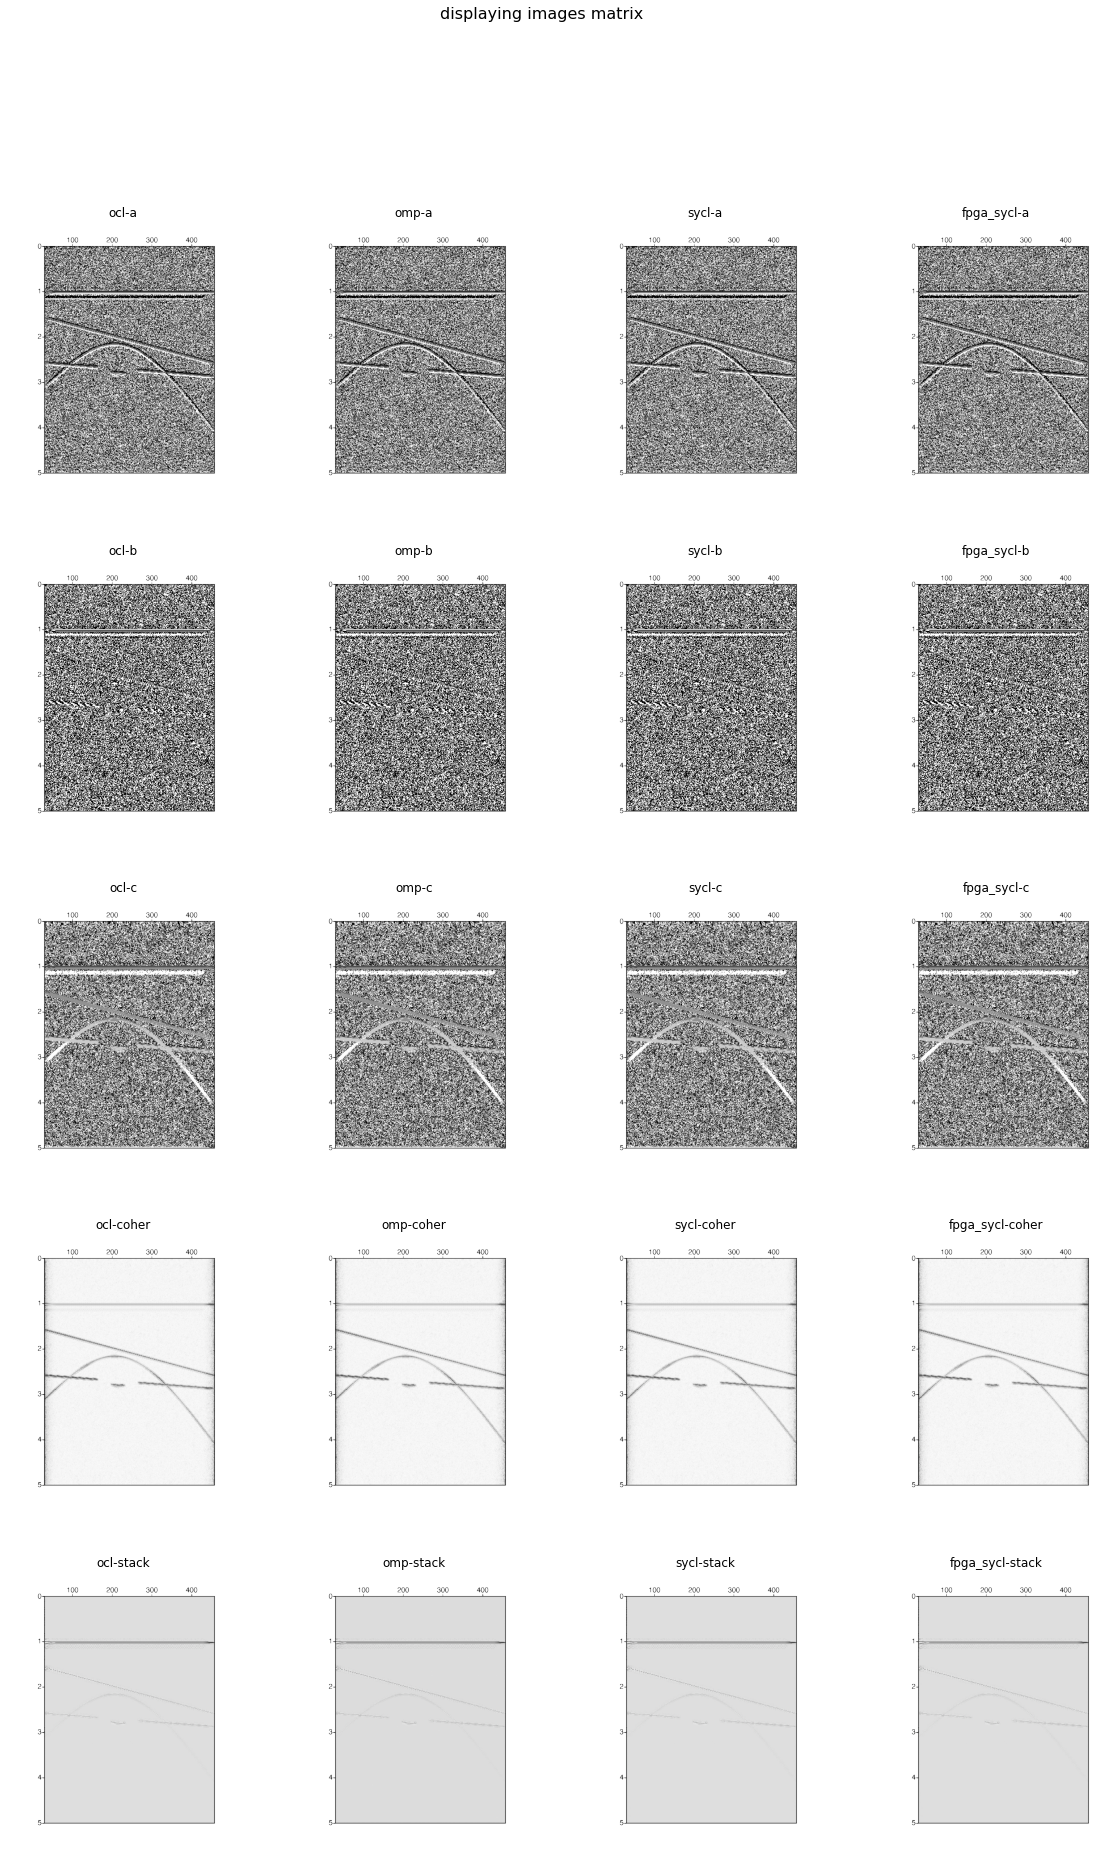

In [33]:
import matplotlib.pyplot as plt

names = ["a", "b", "c", "coher", "stack"]
versions = ["ocl", "omp", "sycl", "fpga_sycl"]

images = []
for i, name in enumerate(names):
    images.append([])
    for j, version in enumerate(versions):
        print("../../datasets/CRS/"+version+"-crs."+name+".png")
        images[i].append(plt.imread("../../datasets/CRS/"+version+"-crs."+name+".png"))
        
NUM_ROWS = len(names)
IMGs_IN_ROW = len(versions)

f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(20, 30))

for i, row in enumerate(ax_arr):
    for j, ax in enumerate(row):
        ax.imshow(images[i][j])
        ax.set_frame_on(False)
        ax.axis('off')
        ax.set_aspect('equal')
        ax.set_title(versions[j]+"-"+names[i])

title = 'displaying images matrix'
f.suptitle(title, fontsize=16)
plt.show()  